In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import Image

In [5]:
sample_image_path = os.path.join(os.getcwd(), 'data', 'img', 'XwsouMoCN2h6wkN1HK9Fmw_90.jpg')

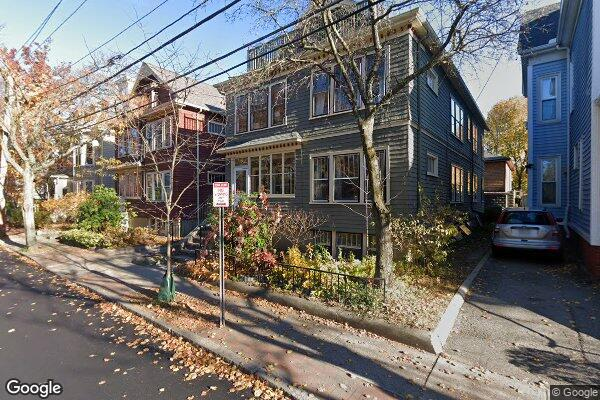

In [6]:
Image(sample_image_path)

## Testing Meta's Segment Anything

First download a model checkpoint [https://github.com/facebookresearch/segment-anything#model-checkpoints]

In [17]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import cv2

In [13]:
sam_checkpoint = "sam_vit_h_4b8939.pth"

model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device='cuda')

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
image = cv2.imread(sample_image_path)

In [16]:
# predictor = SamPredictor(sam)
# predictor.set_image(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- segmentation : the mask
- area : the area of the mask in pixels
- bbox : the boundary box of the mask in XYWH format
- predicted_iou : the model's own prediction for the quality of the mask
- point_coords : the sampled input point that generated this mask
- stability_score : an additional measure of mask quality
- crop_box : the crop of the image used to generate this mask in XYWH format

In [20]:
%%time
masks = mask_generator.generate(image)

In [21]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

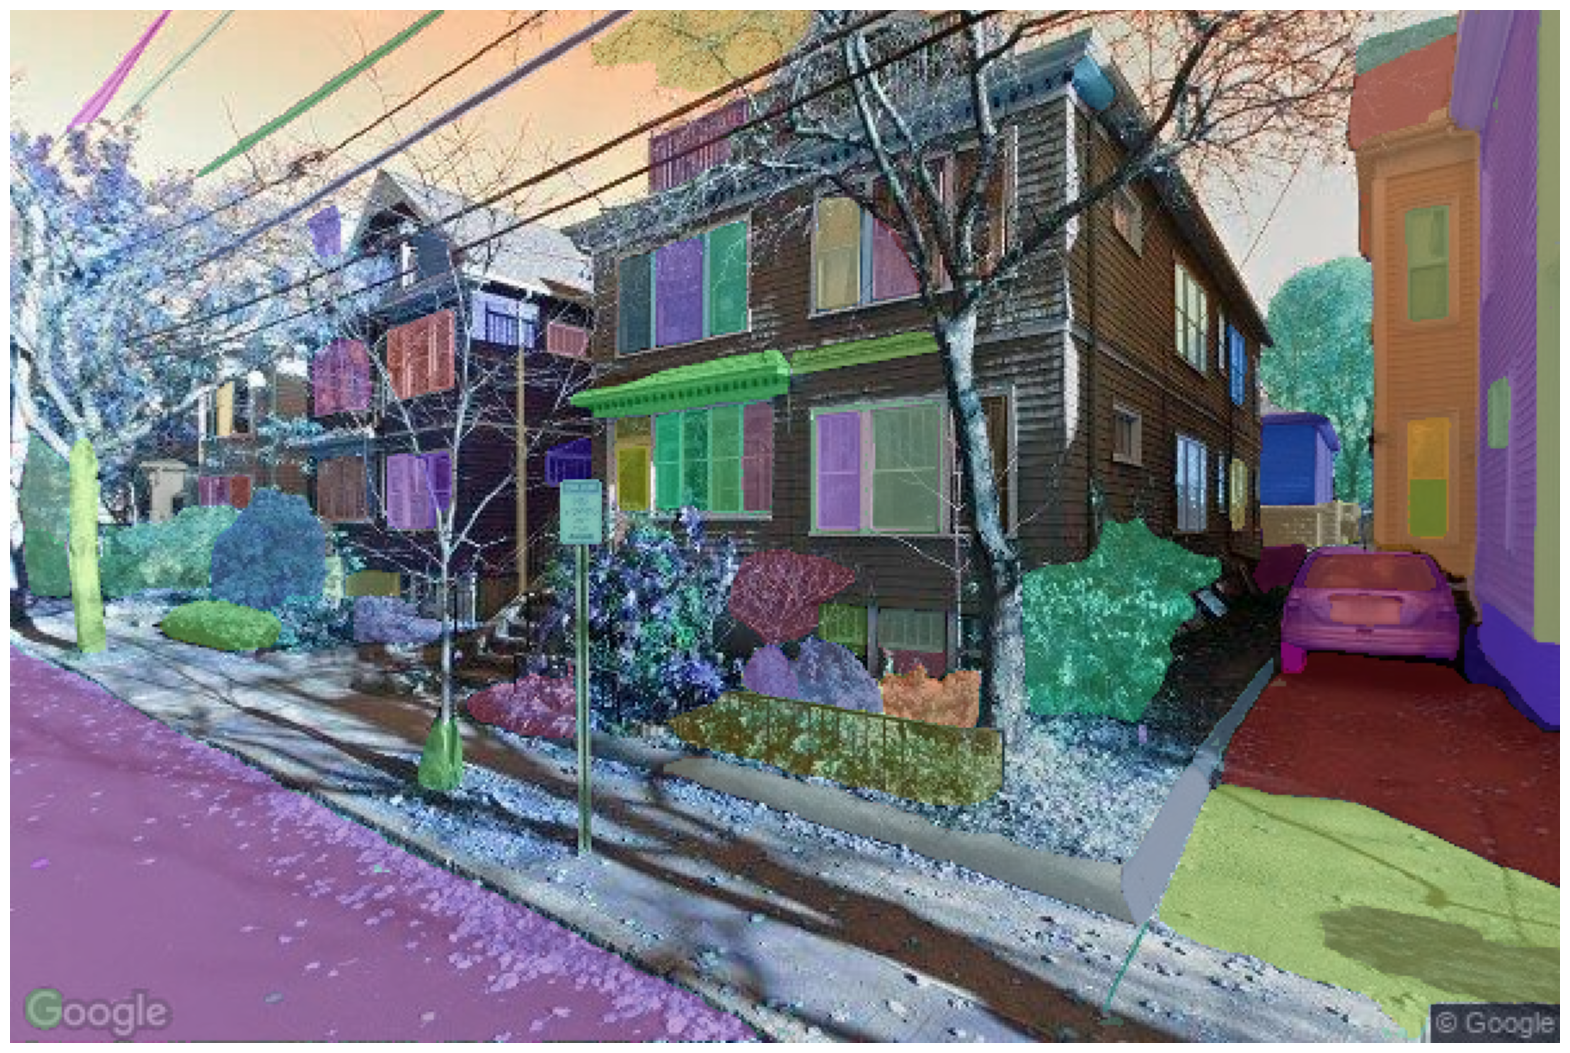

In [22]:
%%time

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [24]:
print(len(masks))
print(masks[0].keys())

114
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [25]:
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)

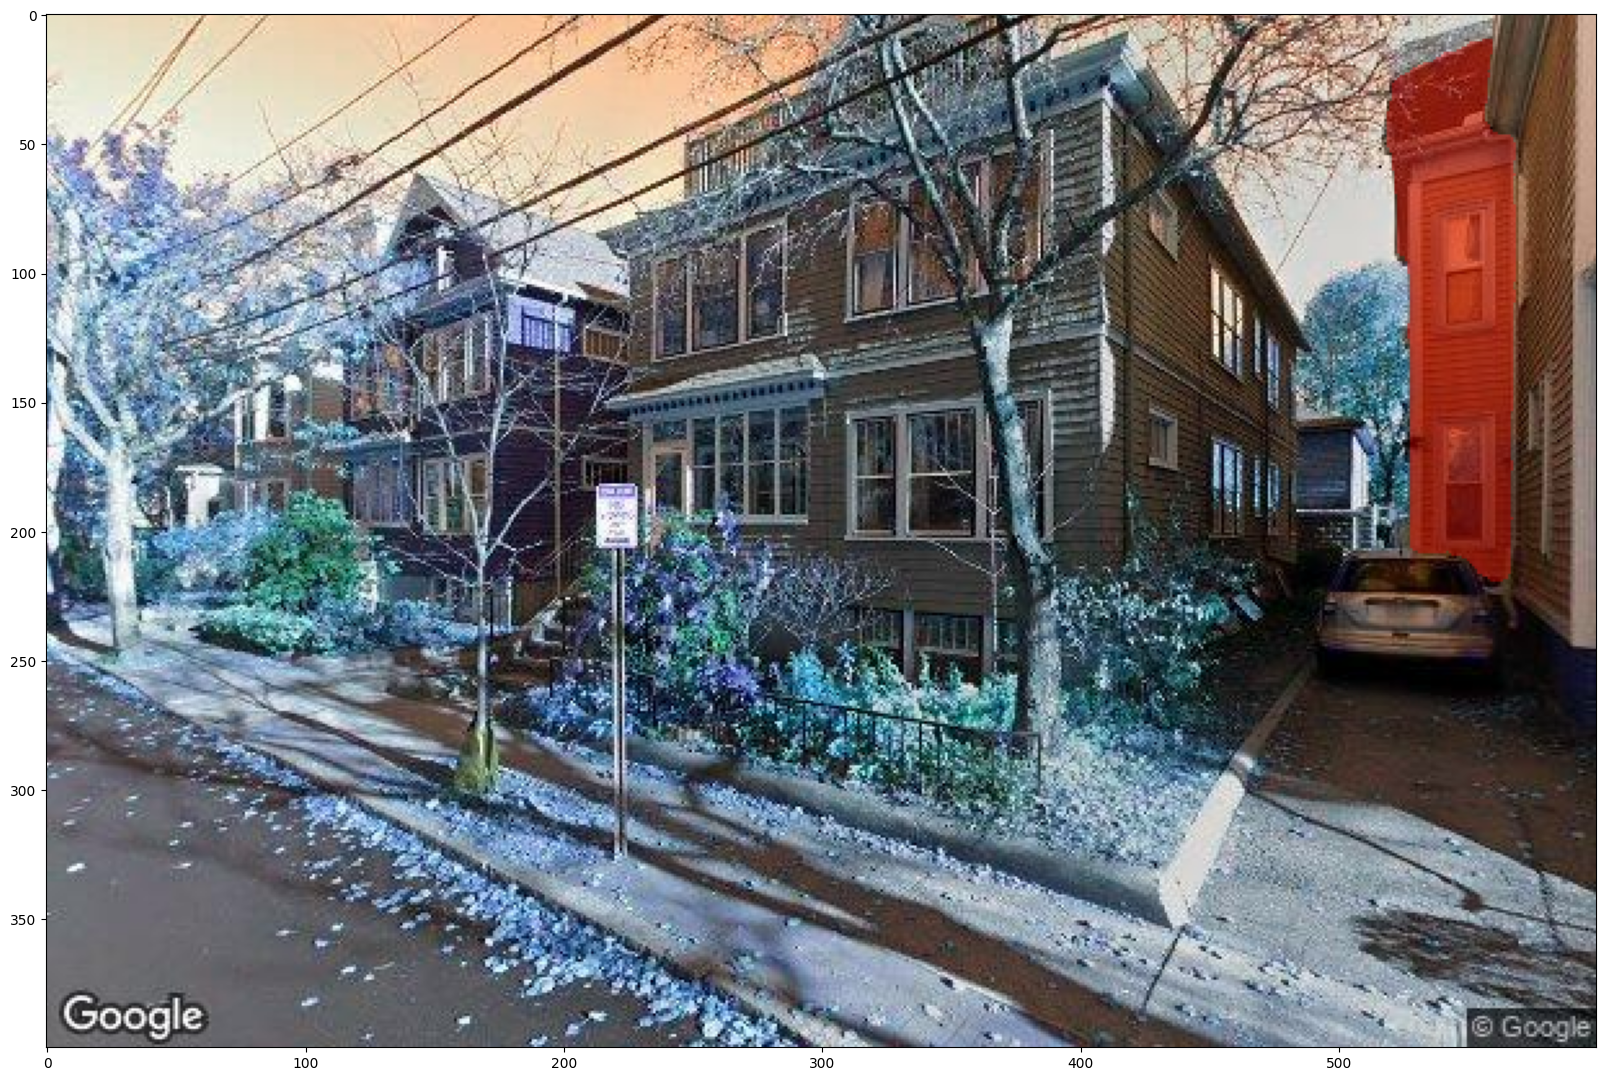

In [39]:
plt.figure(figsize=(20,20))
plt.imshow(image)

i = 6
ann = sorted_anns[i]
m = ann['segmentation']
img = np.ones((m.shape[0], m.shape[1], 3))
# color_mask = np.random.random((1, 3)).tolist()[0]
color_mask = [1, 0, 0]
for i in range(3):
    img[:,:,i] = color_mask[i]
ax = plt.gca()
ax.set_autoscale_on(False)
ax.imshow(np.dstack((img, m*0.35)))

## Testing Detectron2

## Testing DPT

In [45]:
from dpt_segmentation.dpt.models import DPTSegmentationModel
from dpt_segmentation.dpt.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
import torch

model_path = "dpt_segmentation/dpt_hybrid-ade20k-53898607.pt"
model_type = 'dpt_hybrid'
optimize = True

In [43]:
#INITIALIZE MODEL
"""Run segmentation network

Args:
    input_path (str): path to input folder
    output_path (str): path to output folder
    model_path (str): path to saved model
"""
print("initialize")

# select device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("device: %s" % device)

net_w = net_h = 480

# load network
if model_type == "dpt_large":
    model = DPTSegmentationModel(
        150,
        path=model_path,
        backbone="vitl16_384",
    )
elif model_type == "dpt_hybrid":
    model = DPTSegmentationModel(
        150,
        path=model_path,
        backbone="vitb_rn50_384",
    )
else:
    assert (
        False
    ), f"model_type '{model_type}' not implemented, use: --model_type [dpt_large|dpt_hybrid]"

transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        PrepareForNet(),
    ]
)

model.eval()

# if optimize == True and device == torch.device("cuda"):
#     model = model.to(memory_format=torch.channels_last)
#     model = model.half()

# model.to(device)

initialize


DPTSegmentationModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): 

In [52]:
# input
from dpt_segmentation.util import io

scores = []

img = io.read_image(sample_image_path)
img_input = transform({"image": img})["image"]

# compute
with torch.no_grad():
    sample = torch.from_numpy(img_input).unsqueeze(0)
    # sample = torch.from_numpy(img_input).to(device).unsqueeze(0)
    # if optimize == True and device == torch.device("cuda"):
    #     sample = sample.to(memory_format=torch.channels_last)
    #     sample = sample.half()

    out = model.forward(sample)

    prediction = torch.nn.functional.interpolate(
        out, size=img.shape[:2], mode="bicubic", align_corners=False
    )
    prediction = torch.argmax(prediction, dim=1) + 1
    prediction = prediction.squeeze().cpu().numpy()

    for j in range(1,151):
        score = prediction[prediction == j].size/prediction.size
        scores.append(score)

In [51]:
labels = ['wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed', 'window', 
          'grass', 'cabinet', 'sidewalk', 'person', 'earth', 'door', 'table', 'mountain', 
          'plant', 'curtain', 'chair', 'car', 'water', 'painting', 'sofa', 'shelf', 'house', 
          'sea', 'mirror', 'rug', 'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe', 
          'lamp', 'bathtub', 'railing', 'cushion', 'base', 'box', 'column', 'signboard', 'dresser', 
          'counter', 'sand', 'sink', 'skyscraper', 'fireplace', 'refrigerator', 'grandstand', 'path', 
          'stairs', 'runway', 'case', 'pooltable', 'pillow', 'screen', 'stairway', 'river', 'bridge', 
          'bookcase', 'blind', 'coffeetable', 'toilet', 'flower', 'book', 'hill', 'bench', 
          'countertop', 'stove', 'palmtree', 'kitchen', 'computer', 'swivelchair', 'boat', 'bar', 
          'arcade', 'hut', 'bus', 'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 
          'streetlight', 'booth', 'television', 'airplane', 'dirttrack', 'apparel', 'pole', 'land', 
          'balustrade', 'escalator', 'ottoman', 'bottle', 'sideboard', 'poster', 'stage', 'van', 'ship', 
          'fountain', 'conveyerbelt', 'canopy', 'washer', 'toy', 'pool', 'stool', 'barrel', 'basket', 
          'waterfall', 'tent', 'bag', 'motorbike', 'cradle', 'oven', 'ball', 'food', 'step', 'tank', 
          'brandname', 'microwave', 'pot', 'animal', 'bicycle', 'lake', 'dishwasher', 'screen', 'blanket', 
          'sculpture', 'hood', 'sconce', 'vase', 'trafficlight', 'tray', 'trashcan', 'fan', 'pier', 
          'crtscreen', 'plate', 'monitor', 'bulletinboard', 'shower', 'radiator', 'glass', 'clock', 'flag']

In [53]:
scores[1]

0.044083333333333335